https://github.com/bnsreenu/python_for_microscopists/blob/master/166a-Intro_to_time_series_Forecasting_using_LSTM.py

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Flatten, GlobalAveragePooling1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
import tensorflow as tf
import keras as keras
print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)

TensorFlow version: 2.13.0
Keras version: 2.13.1


In [6]:
dataframe = pd.read_csv("data/raw/DAX_Data.csv", usecols=[1])
dataframe = dataframe.dropna()
#plt.plot(dataframe)
dataframe.shape

(9213, 1)

In [7]:
#Convert pandas dataframe to numpy array
dataset = dataframe.values
dataset = dataset.astype('float32')
dataset.shape
# Datentypen ändern von int64 zu float32
# sobald die values sind die bereits float 64 

(9213, 1)

In [8]:
print(dataset.shape)
dataset

(9213, 1)


array([[ 1005.19],
       [  956.49],
       [  996.1 ],
       ...,
       [18406.06],
       [18576.58],
       [18649.08]], dtype=float32)

In [9]:
# LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1)) #Also try QuantileTransformer
dataset = scaler.fit_transform(dataset)
dataset.shape

# Daten umarrangerien damit sie eine Saklierung haben von 0 bis 1. Wobei 1 = max und 0 = min
#scaler.fit = transformiert erst die daten die zeile davor

(9213, 1)

In [10]:
train_size = int(len(dataset) * 0.66)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]


# daten aufteilen in train und test
# validation data kommt er später

In [11]:
def to_sequences(dataset, seq_size=1):
    x = []
    y = []

    for i in range(len(dataset)-seq_size-1):
        #print(i)
        window = dataset[i:(i+seq_size), 0]
        x.append(window)
        y.append(dataset[i+seq_size, 0])
        
    return np.array(x),np.array(y)


# Dieser Prozess hilft dem RNN-Modell, zeitliche Abhängigkeiten 
# und Muster im Datensatz zu lernen, indem es auf frühere Werte in 
# den Sequenzen zurückgreift, um zukünftige Werte vorherzusagen.

In [12]:
seq_size = 5  # Number of time steps to look back 
#Larger sequences (look further back) may improve forecasting.

trainX, trainY = to_sequences(train, seq_size)
testX, testY = to_sequences(test, seq_size)



print("Shape of training set: {}".format(trainX.shape))
print("Shape of test set: {}".format(testX.shape))

Shape of training set: (6074, 5)
Shape of test set: (3127, 5)


In [13]:
# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [21]:
model = Sequential()
model.add(LSTM(64, input_shape=(None, seq_size), return_sequences=True))  # Return sequences is True
model.add(GlobalAveragePooling1D())  # Reduces the output shape to 2D
model.add(Dense(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, None, 64)          17920     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 20033 (78.25 KB)
Trainable params: 20033 (78.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
model.fit(trainX, trainY, validation_data=(testX, testY), verbose=2, epochs=5)

Epoch 1/5
190/190 - 1s - loss: 0.0027 - val_loss: 0.0013 - 1s/epoch - 6ms/step
Epoch 2/5
190/190 - 0s - loss: 3.3235e-05 - val_loss: 0.0010 - 172ms/epoch - 906us/step
Epoch 3/5
190/190 - 0s - loss: 3.1005e-05 - val_loss: 5.4807e-04 - 171ms/epoch - 900us/step
Epoch 4/5
190/190 - 0s - loss: 2.9336e-05 - val_loss: 2.1095e-04 - 172ms/epoch - 907us/step
Epoch 5/5
190/190 - 0s - loss: 2.7989e-05 - val_loss: 1.1747e-04 - 172ms/epoch - 903us/step


In [23]:
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

(6074, 1, 5) (6074,) (3127, 1, 5) (3127,)


In [15]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
trainPredict.shape, testPredict.shape

98/98 [==============================] - 0s 420us/step


((6074, 1), (3127, 1))

In [16]:
trainX.shape, trainY.shape, testX.shape, testY.shape


((6074, 1, 5), (6074,), (3127, 1, 5), (3127,))

In [17]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [18]:
print(trainPredict.shape, trainY.shape)
testPredict.shape, testY.shape

(6074, 1) (1, 6074)


((3127, 1), (1, 3127))

In [19]:
trainPredict[:,0].shape, trainPredict.shape


((6074,), (6074, 1))

In [20]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 87.18 RMSE
Test Score: 183.20 RMSE


In [21]:
# shift train predictions for plotting
#we must shift the predictions so that they align on the x-axis with the original dataset. 
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[seq_size:len(trainPredict)+seq_size, :] = trainPredict

In [22]:
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(seq_size*2)+1:len(dataset)-1, :] = testPredict

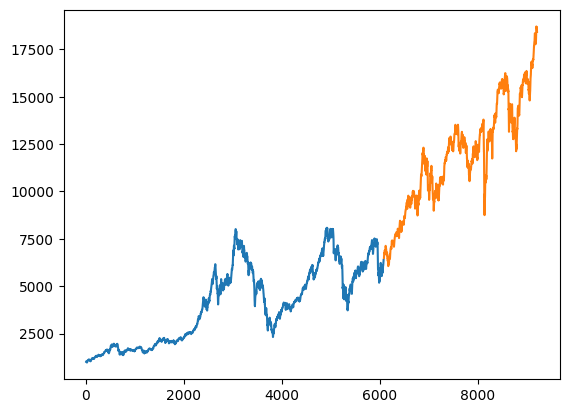

In [23]:
# plot baseline and predictions
#plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()